<a href="https://colab.research.google.com/github/leyixu21/master_thesis/blob/main/clean_foursquare_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparations

In [2]:
! pip install foursquare
! pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 72.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
from datetime import datetime
import math
import pandas as pd
import numpy as np
import geopandas as gpd
import time
import matplotlib.pyplot as plt
import requests
import json
import tqdm

# from dataprep.eda import create_report



In [5]:
# set paths
path='/content/drive/MyDrive/master_thesis_data/'
path_foursquare='/content/drive/MyDrive/master_thesis_data/foursquare/'
path_figures='/content/drive/MyDrive/master_thesis_data/figures/'


In [6]:
# read boundary data
london = gpd.read_file(path+'london_boundaries.geojson')

# Get FSQ Categories

## FSQ doc


Foursquare categories on API documents

This version does not match with Dingqi's Datasets

It is not used to merge with Dingqing's Datasets, and it is just left here in case it might be useful in the future


In [ ]:
# https://location.foursquare.com/developer/reference/search-data
# https://location.foursquare.com/places/docs/categories

In [ ]:
# read the taxonomy in json file
taxonomy = pd.read_json('Countries Supported Taxonomy.json').transpose()[1:]
# rename and drop columnes
taxonomy = taxonomy.reset_index(level=0)
taxonomy.columns = ['id', 'full_label', 'labels', 'parents', 'countries_supported']
taxonomy = taxonomy.drop(columns=['labels', 'countries_supported'])
# extract parent id from the list and convert it to int
taxonomy['parents'] = taxonomy['parents'].apply(lambda x: int(x[0]))
taxonomy

In [ ]:
# get the categories
categories = taxonomy[taxonomy['parents']==1]
categories['full_label'] = categories['full_label'].apply(lambda x: x[0])

categories

In [ ]:
# get the sub_categories and sub_sub_categories
sub_categories = []
sub_sub_categories = []
for idx, row in taxonomy[taxonomy['parents']!=1].iterrows():
    if len(row['full_label']) == 2:
        row['full_label'] = row['full_label'][1]
        sub_categories.append(row)
    else:
        row['full_label'] = row['full_label'][2]
        sub_sub_categories.append(row)
sub_categories = pd.concat(sub_categories, axis=1).transpose()
sub_sub_categories = pd.concat(sub_sub_categories, axis=1).transpose()

In [ ]:
sub_categories

In [ ]:
sub_sub_categories

## FSQ web

Foursquare categories on the web (Foursuqre category list)

This version matches with Dingqi's Datasets

Three csv files are created maunally based on the website http://foursquare-categories.herokuapp.com/

In [22]:
categories = pd.read_csv(path_foursquare+'foursquare_categories/categories.csv')
sub_categories = pd.read_csv(path_foursquare+'foursquare_categories/sub_categories.csv')
# sub_sub_categories has the same id with the sub_categories if the sub-sub-category is within the sub-category
sub_sub_categories = pd.read_csv(path_foursquare+'foursquare_categories/sub_sub_categories.csv')

In [ ]:
categories

,id,full_label
0,10000,Arts & Entertainment
1,11000,College & University
2,12000,Event
3,13000,Food
4,14000,Nightlife Spot
5,15000,Outdoors & Recreation
6,16000,Professional & Other Places
7,17000,Residence
8,18000,Shop & Service
9,19000,Travel & Transport


In [ ]:
sub_categories

,id,full_label
0,10001,Amphitheater
1,10002,Aquarium
2,10003,Arcade
3,10004,Art Gallery
4,10005,Bowling Alley
...,...,...
466,19032,Tram Station
467,19033,Transportation Service
468,19034,Travel Lounge
469,19035,Truck Stop


In [ ]:
sub_sub_categories

,id,full_label
0,10021,Drive-in Theater
1,10021,Indie Movie Theater
2,10021,Multiplex
3,10022,Art Museum
4,10022,Erotic Museum
...,...,...
487,19014,Motel
488,19014,Resort
489,19014,Vacation Rental
490,19031,Platform


sub_sub_categories is too precise, and merge it to sub_categories

In [ ]:
# merge sub_sub_categories into sub_categories
frame = [sub_categories, sub_sub_categories]
sub_categories_merged = pd.concat(frame)
sub_categories_merged

,id,full_label
0,10001,Amphitheater
1,10002,Aquarium
2,10003,Arcade
3,10004,Art Gallery
4,10005,Bowling Alley
...,...,...
487,19014,Motel
488,19014,Resort
489,19014,Vacation Rental
490,19031,Platform


# Clean Dingqi's Datasets

## Worldwide Dataset

Read checkins data

In [ ]:
# read global checkins in text file
df_checkins = pd.read_csv(path_foursquare+'foursquare_yangdingqi/dataset_TIST2015/dataset_TIST2015_Checkins.txt', sep='\t', header=None)
df_checkins.columns = ['User ID', 'Venue ID', 'UTC time', 'Timezone offset in minutes']

In [ ]:
df_checkins

,User ID,Venue ID,UTC time,Timezone offset in minutes
0,50756,4f5e3a72e4b053fd6a4313f6,Tue Apr 03 18:00:06 +0000 2012,240
1,190571,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,180
2,221021,4a85b1b3f964a520eefe1fe3,Tue Apr 03 18:00:08 +0000 2012,-240
3,66981,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300
4,21010,4c2b4e8a9a559c74832f0de2,Tue Apr 03 18:00:09 +0000 2012,240
...,...,...,...,...
33263628,16349,4c957755c8a1bfb7e89024f3,Mon Sep 16 23:24:11 +0000 2013,-240
33263629,256757,4c8bbb6d9ef0224bd2d6667b,Mon Sep 16 23:24:13 +0000 2013,-180
33263630,66425,513e82a5e4b0ed4f0f3bcf2d,Mon Sep 16 23:24:14 +0000 2013,-180
33263631,1830,4b447865f964a5204cf525e3,Mon Sep 16 23:24:14 +0000 2013,120


Read POI data

In [20]:
# read POIs in text file
df_POIs = pd.read_csv(path_foursquare+'foursquare_yangdingqi/dataset_TIST2015/dataset_TIST2015_POIs.txt', sep='\t', header=None)
df_POIs.columns = ['Venue ID', 'Latitude', 'Longitude', 'Venue category name', 'Country code']

In [ ]:
df_POIs

,Venue ID,Latitude,Longitude,Venue category name,Country code
0,3fd66200f964a52000e71ee3,40.733596,-74.003139,Jazz Club,US
1,3fd66200f964a52000e81ee3,40.758102,-73.975734,Gym,US
2,3fd66200f964a52000ea1ee3,40.732456,-74.003755,Indian Restaurant,US
3,3fd66200f964a52000ec1ee3,42.345907,-71.087001,Indian Restaurant,US
4,3fd66200f964a52000ee1ee3,39.933178,-75.159262,Sandwich Place,US
...,...,...,...,...,...
3680121,5237865c498e89110c1d03e7,40.154444,26.410847,Comedy Club,TR
3680122,5237867411d2a1e910744c81,35.340099,33.309328,Home (private),CY
3680123,5237879111d216bab10e9e09,-1.404065,-48.453742,Home (private),BR
3680124,52378c24498ea9502baf2716,3.425155,-76.545010,Sandwich Place,CO


Merge checkins data and POI data

In [ ]:
# join df_checkins and df_POIs on the Venue ID
foursquare_df = df_checkins.merge(df_POIs, on='Venue ID', how='left')
foursquare_df

,User ID,Venue ID,UTC time,Timezone offset in minutes,Latitude,Longitude,Venue category name,Country code
0,50756,4f5e3a72e4b053fd6a4313f6,Tue Apr 03 18:00:06 +0000 2012,240,55.696132,37.557842,Comedy Club,RU
1,190571,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,180,41.029717,28.974420,Other Great Outdoors,TR
2,221021,4a85b1b3f964a520eefe1fe3,Tue Apr 03 18:00:08 +0000 2012,-240,40.748939,-73.992280,Coffee Shop,US
3,66981,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300,30.270753,-97.752936,Office,US
4,21010,4c2b4e8a9a559c74832f0de2,Tue Apr 03 18:00:09 +0000 2012,240,59.941041,30.308104,Bridge,RU
...,...,...,...,...,...,...,...,...
33263628,16349,4c957755c8a1bfb7e89024f3,Mon Sep 16 23:24:11 +0000 2013,-240,40.712411,-74.010150,Government Building,US
33263629,256757,4c8bbb6d9ef0224bd2d6667b,Mon Sep 16 23:24:13 +0000 2013,-180,-33.464153,-70.702754,Fire Station,CL
33263630,66425,513e82a5e4b0ed4f0f3bcf2d,Mon Sep 16 23:24:14 +0000 2013,-180,-1.465807,-48.492513,Gym,BR
33263631,1830,4b447865f964a5204cf525e3,Mon Sep 16 23:24:14 +0000 2013,120,51.042473,3.725953,Plaza,BE


Save merged checkins data and POI data

In [ ]:
# # save the foursquare_df
# foursquare_df.to_pickle(path_foursquare+'global_foursquare_df.pkl')

# read the foursquare_df
foursquare_df = pd.read_pickle(path_foursquare+'global_foursquare_df.pkl')

## Greater London Dataset

Extract data in Greater Britain

In [ ]:
# extract checkins in Greater Britain
df_gb = foursquare_df[foursquare_df['Country code']=='GB']


Extract data in Greater London

In [ ]:
# convert the df_gb to geodataframe
gdf_gb = gpd.GeoDataFrame(
    df_gb, geometry=gpd.points_from_xy(df_gb.Longitude, df_gb.Latitude, crs='epsg:4326')
)

# select data in London
gdf_london = gdf_gb[gdf_gb.within(london.unary_union)]


In [ ]:
gdf_london

,User ID,Venue ID,UTC time,Timezone offset in minutes,Latitude,Longitude,Venue category name,Country code,geometry
45,262915,4aec9f4bf964a52091c921e3,Tue Apr 03 18:00:39 +0000 2012,60,51.498044,-0.090546,Pub,GB,POINT (-0.09055 51.49804)
251,78404,4b9024ccf964a5204a7833e3,Tue Apr 03 18:02:55 +0000 2012,60,51.514978,-0.302248,Restaurant,GB,POINT (-0.30225 51.51498)
359,209258,4bd9dff02a3a0f4726a7a8b6,Tue Apr 03 18:04:06 +0000 2012,60,51.516956,-0.070255,Indian Restaurant,GB,POINT (-0.07025 51.51696)
608,3409,4b044900f964a520e05222e3,Tue Apr 03 18:07:02 +0000 2012,60,51.507220,-0.221701,Portuguese Restaurant,GB,POINT (-0.22170 51.50722)
699,109689,4f6880ce6b74aa26bb61f7ac,Tue Apr 03 18:08:09 +0000 2012,60,51.522703,-0.085487,Coworking Space,GB,POINT (-0.08549 51.52270)
...,...,...,...,...,...,...,...,...,...
33260210,72218,4bdafe52c79cc928548e80e9,Mon Sep 16 21:33:32 +0000 2013,60,51.590283,-0.102932,Subway,GB,POINT (-0.10293 51.59028)
33260707,144,50561a46e4b04495bdaa1548,Mon Sep 16 21:51:44 +0000 2013,60,51.478380,-0.345140,Neighborhood,GB,POINT (-0.34514 51.47838)
33261890,18132,4c321a19ac0ab7138f651c1e,Mon Sep 16 22:32:55 +0000 2013,60,51.500526,-0.092377,Pub,GB,POINT (-0.09238 51.50053)
33262116,239333,4ac518c8f964a5207ca520e3,Mon Sep 16 22:39:26 +0000 2013,60,51.508015,-0.124283,Nightclub,GB,POINT (-0.12428 51.50802)


In [ ]:
len(list(gdf_london['User ID'].unique()))

9717

Convert to time

In [ ]:
# convert to time
gdf_london['UTC time'] = gdf_london['UTC time'].apply(lambda x: datetime.strptime(x, '%a %b %d %H:%M:%S %z %Y'))
gdf_london['time'] = pd.to_datetime(gdf_london['UTC time'])


c:\Users\leyix\anaconda3\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\leyix\anaconda3\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Drop unused columns

In [ ]:
# drop unused columns
gdf_london = gdf_london.drop(columns=['UTC time', 'Timezone offset in minutes', 'Latitude', 'Longitude', 'Country code'])


Drop duplicates

In [ ]:
# drop duplicates
gdf_london = gdf_london.drop_duplicates()


Remove users with less than 3 checkins within a day

In [ ]:
# extract date
gdf_london['date'] = gdf_london['time'].apply(lambda x: x.date())

# group data by date and user
gdf_london['date'] = gdf_london['time'].apply(lambda x: x.date())
gdf_london_gb = gdf_london.groupby(['date', 'User ID']).count()
gdf_london_gb = gdf_london_gb.sort_values('Venue ID')
gdf_london_gb.reset_index(inplace=True)

gdf_london_gb


,date,User ID,Venue ID,Venue category name,geometry,time
0,2013-09-16,262979,1,1,1,1
1,2012-12-21,50547,1,1,1,1
2,2012-12-21,49261,1,1,1,1
3,2012-12-21,47623,1,1,1,1
4,2013-06-30,110244,1,1,1,1
...,...,...,...,...,...,...
104788,2012-04-14,81509,36,36,36,36
104789,2012-05-04,26873,38,38,38,38
104790,2012-04-13,81509,41,41,41,41
104791,2013-02-02,259,44,44,44,44


In [ ]:
# get users and date with less than 3 checkins within a day
users_remove = gdf_london_gb[gdf_london_gb['Venue ID']<3]
users_remove

,date,User ID,Venue ID,Venue category name,geometry,time
0,2013-09-16,262979,1,1,1,1
1,2012-12-21,50547,1,1,1,1
2,2012-12-21,49261,1,1,1,1
3,2012-12-21,47623,1,1,1,1
4,2013-06-30,110244,1,1,1,1
...,...,...,...,...,...,...
87743,2012-05-21,132404,2,2,2,2
87744,2013-02-21,10697,2,2,2,2
87745,2013-02-25,43714,2,2,2,2
87746,2012-05-21,102995,2,2,2,2


In [ ]:
# remove records that apply to users_remove
for idx, row in users_remove.iterrows():
  date_to_remove = row['date']
  user_to_remove = row['User ID']
  gdf_london.drop(gdf_london[(gdf_london['date']==date_to_remove) & (t['User ID']==user_to_remove)].index)

gdf_london

,User ID,Venue ID,Venue category name,geometry,time,date
45,262915,4aec9f4bf964a52091c921e3,Pub,POINT (-0.09055 51.49804),2012-04-03 18:00:39+00:00,2012-04-03
251,78404,4b9024ccf964a5204a7833e3,Restaurant,POINT (-0.30225 51.51498),2012-04-03 18:02:55+00:00,2012-04-03
359,209258,4bd9dff02a3a0f4726a7a8b6,Indian Restaurant,POINT (-0.07025 51.51696),2012-04-03 18:04:06+00:00,2012-04-03
608,3409,4b044900f964a520e05222e3,Portuguese Restaurant,POINT (-0.22170 51.50722),2012-04-03 18:07:02+00:00,2012-04-03
699,109689,4f6880ce6b74aa26bb61f7ac,Coworking Space,POINT (-0.08549 51.52270),2012-04-03 18:08:09+00:00,2012-04-03
...,...,...,...,...,...,...
33260210,72218,4bdafe52c79cc928548e80e9,Subway,POINT (-0.10293 51.59028),2013-09-16 21:33:32+00:00,2013-09-16
33260707,144,50561a46e4b04495bdaa1548,Neighborhood,POINT (-0.34514 51.47838),2013-09-16 21:51:44+00:00,2013-09-16
33261890,18132,4c321a19ac0ab7138f651c1e,Pub,POINT (-0.09238 51.50053),2013-09-16 22:32:55+00:00,2013-09-16
33262116,239333,4ac518c8f964a5207ca520e3,Nightclub,POINT (-0.12428 51.50802),2013-09-16 22:39:26+00:00,2013-09-16


Remove checkins that are Home (private) to protect users' privacy

In [ ]:
# remove checkins that are Home (private)	to protect users' privacy
gdf_london = gdf_london[gdf_london['Venue category name']!='Home (private)']


In [ ]:
gdf_london

,User ID,Venue ID,Venue category name,geometry,time,date
45,262915,4aec9f4bf964a52091c921e3,Pub,POINT (-0.09055 51.49804),2012-04-03 18:00:39+00:00,2012-04-03
251,78404,4b9024ccf964a5204a7833e3,Restaurant,POINT (-0.30225 51.51498),2012-04-03 18:02:55+00:00,2012-04-03
359,209258,4bd9dff02a3a0f4726a7a8b6,Indian Restaurant,POINT (-0.07025 51.51696),2012-04-03 18:04:06+00:00,2012-04-03
608,3409,4b044900f964a520e05222e3,Portuguese Restaurant,POINT (-0.22170 51.50722),2012-04-03 18:07:02+00:00,2012-04-03
699,109689,4f6880ce6b74aa26bb61f7ac,Coworking Space,POINT (-0.08549 51.52270),2012-04-03 18:08:09+00:00,2012-04-03
...,...,...,...,...,...,...
33260070,9671,4fe85037e4b0af2e68221581,Casino,POINT (-0.12893 51.51150),2013-09-16 21:28:19+00:00,2013-09-16
33260210,72218,4bdafe52c79cc928548e80e9,Subway,POINT (-0.10293 51.59028),2013-09-16 21:33:32+00:00,2013-09-16
33260707,144,50561a46e4b04495bdaa1548,Neighborhood,POINT (-0.34514 51.47838),2013-09-16 21:51:44+00:00,2013-09-16
33261890,18132,4c321a19ac0ab7138f651c1e,Pub,POINT (-0.09238 51.50053),2013-09-16 22:32:55+00:00,2013-09-16


Save preprocessed gdf_london

In [ ]:
# # save the preprocessed gdf_london
# gdf_london.to_pickle(path_foursquare+'london_foursquare.pkl')

# read the preprocessed gdf_london
gdf_london = pd.read_pickle(path_foursquare+'london_foursquare.pkl')

# Merge FSQ Categories with Dingqi's Dataset

## Replace Unmatched Categories Manually

There are mismatches of categories between the latest Foursquare category list and Qingqi's dataset,    
the categories in Qingqi's dataset but not in latest Foursquare category list should be extracted, and they will be renamed based on the latest Foursquare category list.

In [ ]:
# get the categories not in the latest FSQ categories
categories_notin = []
for i in gdf_london['Venue category name'].unique().tolist():
    if i not in categories['full_label'].tolist() and i not in sub_sub_categories['full_label'].tolist() and i not in sub_categories_merged['full_label'].tolist():
        categories_notin.append(i)
categories_notin = pd.DataFrame(categories_notin, columns=['old'])

In [ ]:
categories_notin

,old
0,Caf
1,Subway
2,Malaysian Restaurant
3,Spa / Massage
4,Drugstore / Pharmacy
5,Caf
6,Light Rail
7,Mall
8,Ramen / Noodle House
9,Gas Station / Garage


In [ ]:
# add new column storing the new venue category name
categories_notin['new'] = 0
categories_notin.loc[0, 'new'] = 'Cafeteria'
categories_notin.loc[1, 'new'] = 'Metro Station'
categories_notin.loc[2, 'new'] = 'Asian Restaurant'
categories_notin.loc[3, 'new'] = 'Spa'
categories_notin.loc[4, 'new'] = 'Drugstore'
categories_notin.loc[5, 'new'] = 'Café'
categories_notin.loc[6, 'new'] = 'Light Rail Station'
categories_notin.loc[7, 'new'] = 'Outlet Mall'
categories_notin.loc[8, 'new'] = 'Ramen Restaurant'
categories_notin.loc[9, 'new'] = 'Gas Station'
categories_notin.loc[10, 'new'] = 'Tennis Court'
categories_notin.loc[11, 'new'] = 'Auto Dealership'
categories_notin.loc[12, 'new'] = 'Bike Trail'
categories_notin.loc[13, 'new'] = 'Athletics & Sports'
categories_notin.loc[14, 'new'] = 'Frozen Yogurt Shop'
categories_notin.loc[15, 'new'] = 'Martial Arts School'
categories_notin.loc[16, 'new'] = 'Frozen Yogurt Shop'
categories_notin.loc[17, 'new'] = 'Research Laboratory'
categories_notin.loc[18, 'new'] = 'Boat or Ferry'


In [ ]:
categories_notin

,old,new
0,Caf,Cafeteria
1,Subway,Metro Station
2,Malaysian Restaurant,Asian Restaurant
3,Spa / Massage,Spa
4,Drugstore / Pharmacy,Drugstore
5,Caf,Café
6,Light Rail,Light Rail Station
7,Mall,Outlet Mall
8,Ramen / Noodle House,Ramen Restaurant
9,Gas Station / Garage,Gas Station


In [ ]:
# convert the old venue category name to the new one in gdf_london
for idx, row in gdf_london.iterrows():
    name = row['Venue category name']
    if name in categories_notin['old'].tolist():
        gdf_london.loc[idx, 'Venue category name'] = categories_notin[categories_notin['old']==name]['new'].values[0]
gdf_london

,User ID,Venue ID,Venue category name,geometry,time,date
45,262915,4aec9f4bf964a52091c921e3,Pub,POINT (-0.09055 51.49804),2012-04-03 18:00:39+00:00,2012-04-03
251,78404,4b9024ccf964a5204a7833e3,Restaurant,POINT (-0.30225 51.51498),2012-04-03 18:02:55+00:00,2012-04-03
359,209258,4bd9dff02a3a0f4726a7a8b6,Indian Restaurant,POINT (-0.07025 51.51696),2012-04-03 18:04:06+00:00,2012-04-03
608,3409,4b044900f964a520e05222e3,Portuguese Restaurant,POINT (-0.22170 51.50722),2012-04-03 18:07:02+00:00,2012-04-03
699,109689,4f6880ce6b74aa26bb61f7ac,Coworking Space,POINT (-0.08549 51.52270),2012-04-03 18:08:09+00:00,2012-04-03
...,...,...,...,...,...,...
33260070,9671,4fe85037e4b0af2e68221581,Casino,POINT (-0.12893 51.51150),2013-09-16 21:28:19+00:00,2013-09-16
33260210,72218,4bdafe52c79cc928548e80e9,Metro Station,POINT (-0.10293 51.59028),2013-09-16 21:33:32+00:00,2013-09-16
33260707,144,50561a46e4b04495bdaa1548,Neighborhood,POINT (-0.34514 51.47838),2013-09-16 21:51:44+00:00,2013-09-16
33261890,18132,4c321a19ac0ab7138f651c1e,Pub,POINT (-0.09238 51.50053),2013-09-16 22:32:55+00:00,2013-09-16


In [ ]:
gdf_london['User ID'].value_counts()

321       1573
144       1266
722       1134
1022       934
876        915
          ... 
203804       1
112630       1
117536       1
248660       1
231034       1
Name: User ID, Length: 9705, dtype: int64

## Merge Checkins with FSQ Categories

In [ ]:
# get unique categories of checkins
checkins_categories = gdf_london['Venue category name'].unique().tolist()
checkins_categories = pd.DataFrame (checkins_categories, columns = ['Venue category name'])

# add the id and sub_id column
checkins_categories['id'] = 0
checkins_categories['sub_id'] = 0
checkins_categories['category'] = 0
checkins_categories['sub_category'] = 0
checkins_categories

,Venue category name,id,sub_id,category,sub_category
0,Pub,0,0,0,0
1,Restaurant,0,0,0,0
2,Indian Restaurant,0,0,0,0
3,Portuguese Restaurant,0,0,0,0
4,Coworking Space,0,0,0,0
...,...,...,...,...,...
392,Well,0,0,0,0
393,Middle School,0,0,0,0
394,Mac & Cheese Joint,0,0,0,0
395,Research Laboratory,0,0,0,0


In [ ]:
# get the id and sub_id of the checkins_categories
idx = 0
for idx, row in checkins_categories.iterrows():
    venue_name = row['Venue category name']
    if venue_name in categories['full_label'].tolist():
        checkins_categories.loc[idx, 'id'] = categories[categories['full_label']==venue_name]['id'].values[0]
        checkins_categories.loc[idx, 'category'] = categories[categories['full_label']==venue_name]['full_label'].values[0]
    elif venue_name in sub_categories_merged['full_label'].tolist():
        sub_id = sub_categories_merged[sub_categories_merged['full_label']==venue_name]['id'].values[0]
        id = math.floor(sub_id/1000)*1000
        checkins_categories.loc[idx, 'sub_id'] = sub_id
        checkins_categories.loc[idx, 'id'] = id
        checkins_categories.loc[idx, 'sub_category'] = sub_categories_merged[sub_categories_merged['id']==sub_id]['full_label'].values[0]
        checkins_categories.loc[idx, 'category'] = categories[categories['id']==id]['full_label'].values[0]


In [ ]:
checkins_categories = checkins_categories.sort_values('id')
checkins_categories

,Venue category name,id,sub_id,category,sub_category
172,Arcade,10000,10003,Arts & Entertainment,Arcade
345,Baseball Stadium,10000,10033,Arts & Entertainment,Stadium
258,Basketball Stadium,10000,10033,Arts & Entertainment,Stadium
222,Indie Movie Theater,10000,10021,Arts & Entertainment,Movie Theater
336,Dance Studio,10000,10025,Arts & Entertainment,Performing Arts Venue
...,...,...,...,...,...
289,Hotel Pool,19000,19014,Travel & Transport,Hotel
73,Bus Line,19000,19008,Travel & Transport,Bus Stop
156,Pier,19000,19020,Travel & Transport,Pier
16,Metro Station,19000,19018,Travel & Transport,Metro Station


In [ ]:
checkins_categories['category'].value_counts()

In [ ]:
# merge gdf_london with checkins_categories
gdf_london_merged = pd.merge(gdf_london, checkins_categories, on = 'Venue category name')

Save the gdf_london_merged

In [ ]:
# # save the data as pickel
# gdf_london_merged.to_pickle(path_foursquare+'london_foursquare_merged.pkl')

# read the data
gdf_london_merged = pd.read_pickle(path_foursquare+'london_foursquare_merged.pkl')

In [ ]:
gdf_london_merged

,User ID,Venue ID,Venue category name,geometry,time,date,id,sub_id,category,sub_category
0,262915,4aec9f4bf964a52091c921e3,Pub,POINT (-0.09055 51.49804),2012-04-03 18:00:39+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar
1,176394,4ad9f6ddf964a520751c21e3,Pub,POINT (-0.10401 51.52012),2012-04-03 18:15:19+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar
2,163591,4ae0acf4f964a5208c8121e3,Pub,POINT (-0.02066 51.58778),2012-04-03 18:38:58+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar
3,206428,4adb1972f964a5205f2421e3,Pub,POINT (-0.14356 51.55852),2012-04-03 18:41:27+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar
4,18883,4ac518baf964a520dea120e3,Pub,POINT (-0.17742 51.55664),2012-04-03 18:47:29+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar
...,...,...,...,...,...,...,...,...,...,...
182123,544,51692f22e4b04a6f7dca039d,Middle School,POINT (-0.24022 51.48726),2013-04-19 06:38:30+00:00,2013-04-19,16000,16036,Professional & Other Places,School
182124,544,51692f22e4b04a6f7dca039d,Middle School,POINT (-0.24022 51.48726),2013-04-21 11:18:59+00:00,2013-04-21,16000,16036,Professional & Other Places,School
182125,12623,4f73185be4b042cc9614a94f,Mac & Cheese Joint,POINT (-0.14639 51.54118),2013-06-07 12:58:42+00:00,2013-06-07,13000,13060,Food,Mac & Cheese Joint
182126,158095,5196543b498ea8ef66acbc69,Research Laboratory,POINT (-0.14847 51.52229),2013-07-04 15:38:07+00:00,2013-07-04,16000,16034,Professional & Other Places,Research Laboratory


## Collect Foursquare Venue Names

In [ ]:
# get the list of unique venue id
venues_ls = list(gdf_london_merged['Venue ID'].unique())
len(list(gdf_london_merged['Venue ID'].unique()))

27608

In [ ]:
# create a dataframe to store venue names
venues_info = pd.DataFrame(venues_ls, columns=['Venue ID'])

# add the venue name column
venues_info['venue_name'] = 'None'

Foursquare API 1: fsq3SA2r/INEiszcpAcb94IvEE0c2czJftnxoYPSkHBx+x8=   
Foursquare API 2: fsq3C2PSDwUlQNwuiOq0z5ZMci/cq004Vvv9uOVvs77cvQ4=

In [ ]:
# collect venue names via Foursquare API
# https://location.foursquare.com/developer/reference/place-details
headers = {
    "accept": "application/json",
    "Authorization": "fsq3SA2r/INEiszcpAcb94IvEE0c2czJftnxoYPSkHBx+x8="
}

for idx, row in venues_info.iterrows():
    venue_id = row['Venue ID']
    url = "https://api.foursquare.com/v3/places/{}".format(venue_id)
    response = requests.get(url, headers=headers)
    if 'invalid venue specified' not in response.text:
        response_json = json.loads(response.text)
        venueName = response_json['name']
        venues_info.loc[idx, 'venue_name'] = venueName
        print(idx)
        print(venueName)

# replace the whitespace with None
venues_info = venues_info.replace('', 'None')

# save the venue names
venues_info.to_pickle(path_foursquare+'foursquare_venues_info.pkl')

# Identify Locals and Tourists

## Collect Fourquare User Profiles

In [ ]:
# group the gdf_london_merged by user id
gdf_gb_users = gdf_london_merged.groupby('User ID', as_index=False)

# get the list of unique user id
users_ls = sorted(list(gdf_london_merged['User ID'].unique()))

In [ ]:
len(users_ls)

9705

In [ ]:
# create a dataframe to store the user profiles
users_profile = pd.DataFrame (users_ls, columns = ['User ID'])

# add the countryCode and homeCity column
users_profile['country_code'] = 'None'
users_profile['home_city'] = 'None'

oauth_token 1: OLUGEPPYVVB4ZGBN0JZT045BVPHXD2EEGGQNZY5EONYIPI5X

oauth_token 2: MLVQSHI5ZGHT45DXDYYHPRX3V01UITSD4HJBVAN4W4XYT2XG

In [ ]:
# collect user profiles via Foursquare API
# https://location.foursquare.com/developer/reference/v2-users-user_id
for idx, row in users_profile.iterrows():
    user_id = row['User ID']
    url = "https://api.foursquare.com/v2/users/{}?oauth_token=OLUGEPPYVVB4ZGBN0JZT045BVPHXD2EEGGQNZY5EONYIPI5X&v=20220722".format(user_id)
    response = requests.get(url)
    response_json = json.loads(response.text)
    if 'user' in response_json['response'].keys():
        if 'countryCode' in response_json['response']['user'].keys():
            countryCode = response_json['response']['user']['countryCode']
            users_profile.loc[idx, 'country_code'] = countryCode
        if 'homeCity' in response_json['response']['user'].keys():
            homeCity = response_json['response']['user']['homeCity']
            users_profile.loc[idx, 'home_city'] = homeCity
    print(idx)
    print(countryCode+','+homeCity)

# replace the whitespace with None
users_profile = users_profile.replace('', 'None')

# save the user profile
users_profile.to_pickle(path_foursquare+'foursquare_users_profile.pkl')

In [ ]:
users_profile = pd.read_pickle(path_foursquare+'foursquare_users_profile.pkl')
users_profile

,User ID,country_code,home_city,interval,tourist
0,9,None,None,2,y
1,55,US,"Jakarta, Jakarta, Indonesia",410,y
2,65,US,"New York, NY",20,y
3,68,None,None,1,y
4,116,None,None,142,n
...,...,...,...,...,...
9700,266640,MY,"Petaling Jaya, Selangor",1,y
9701,266687,ID,Indonesia,1,y
9702,266894,None,None,71,n
9703,266904,JP,"世田谷区, 日本",4,y


## Get Time Intervals (Days) of Users

In [ ]:
# create the dataframe user_info, containing user profiles and time intervals (days)
users_info = users_profile.copy()
users_info['interval'] = 0

In [ ]:
# calculate the time interval of each user
for idx, row in users_info.iterrows():
    user_id = row['User ID']
    user = gdf_gb_users.get_group(user_id)
    user = user.sort_values('date')
    # the time interval is 1 if there is only one record in this user's dataframe
    if len(user) == 1:
        interval = 1
    else:
        interval = (user['date'].iloc[-1] - user['date'].iloc[0]).days + 1
    users_info.loc[idx, 'interval'] = interval
users_info

,User ID,country_code,home_city,interval
0,9,None,None,2
1,55,US,"Jakarta, Jakarta, Indonesia",410
2,65,US,"New York, NY",20
3,68,None,None,1
4,116,None,None,142
...,...,...,...,...
9700,266640,MY,"Petaling Jaya, Selangor",1
9701,266687,ID,Indonesia,1
9702,266894,None,None,71
9703,266904,JP,"世田谷区, 日本",4


## Identify Locals and Tourists based on User Profiles and Time Intervals

In [ ]:
# add the column tourist to indicate whether the user is a tourist or a local (y means tourist, n means local)
# assume all users are tourists first
users_info['tourist'] = 'y'

# iterate users to find locals based on the user profile and interval
for idx, row in users_info.iterrows():
  # label the users whose home city is London as locals
  if row['home_city'] != 'None':
    if 'London' in row['home_city']:
      users_info.loc[idx, 'tourist'] = 'n'
  # labels the users who do not have home city information, and whose interval larger than 30 as locals
  else:
    if row['interval'] > 30:
      if row['country_code'] == 'GB' or row['country_code'] == 'None':
        users_info.at[idx, 'tourist'] = 'n'


In [ ]:
# # save users_info
# users_info.to_pickle(path_foursquare+'foursquare_users_info.pkl')
users_info = pd.read_pickle(path_foursquare+'foursquare_users_info.pkl')

In [ ]:
# check tourists
users_info[users_info['tourist']=='y']

,User ID,country_code,home_city,interval,tourist
0,9,None,None,2,y
1,55,US,"Jakarta, Jakarta, Indonesia",410,y
2,65,US,"New York, NY",20,y
3,68,None,None,1,y
5,117,None,None,1,y
...,...,...,...,...,...
9699,266637,DE,"Fürstenwalde/Spree, Brandenburg",16,y
9700,266640,MY,"Petaling Jaya, Selangor",1,y
9701,266687,ID,Indonesia,1,y
9703,266904,JP,"世田谷区, 日本",4,y


In [ ]:
# check locals
users_info[users_info['tourist']=='n']

,User ID,country_code,home_city,interval,tourist
4,116,None,None,142,n
8,151,None,None,414,n
17,266,None,None,131,n
20,285,None,None,83,n
21,291,None,None,217,n
...,...,...,...,...,...
9616,263777,None,None,490,n
9644,264315,None,None,520,n
9665,264793,None,None,388,n
9687,265825,None,None,204,n


In [ ]:
# merge users_info with gdf_london_merged
gdf_london_cleaned = gdf_london_merged.merge(users_info, on='User ID', how='left')
gdf_london_cleaned = gdf_london_cleaned.drop(columns=['country_code', 'home_city', 'interval'])

gdf_london_cleaned

,User ID,Venue ID,Venue category name,geometry,time,date,id,sub_id,category,sub_category,tourist
0,262915,4aec9f4bf964a52091c921e3,Pub,POINT (-0.09055 51.49804),2012-04-03 18:00:39+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y
1,176394,4ad9f6ddf964a520751c21e3,Pub,POINT (-0.10401 51.52012),2012-04-03 18:15:19+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y
2,163591,4ae0acf4f964a5208c8121e3,Pub,POINT (-0.02066 51.58778),2012-04-03 18:38:58+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,n
3,206428,4adb1972f964a5205f2421e3,Pub,POINT (-0.14356 51.55852),2012-04-03 18:41:27+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y
4,18883,4ac518baf964a520dea120e3,Pub,POINT (-0.17742 51.55664),2012-04-03 18:47:29+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y
...,...,...,...,...,...,...,...,...,...,...,...
182123,544,51692f22e4b04a6f7dca039d,Middle School,POINT (-0.24022 51.48726),2013-04-19 06:38:30+00:00,2013-04-19,16000,16036,Professional & Other Places,School,y
182124,544,51692f22e4b04a6f7dca039d,Middle School,POINT (-0.24022 51.48726),2013-04-21 11:18:59+00:00,2013-04-21,16000,16036,Professional & Other Places,School,y
182125,12623,4f73185be4b042cc9614a94f,Mac & Cheese Joint,POINT (-0.14639 51.54118),2013-06-07 12:58:42+00:00,2013-06-07,13000,13060,Food,Mac & Cheese Joint,n
182126,158095,5196543b498ea8ef66acbc69,Research Laboratory,POINT (-0.14847 51.52229),2013-07-04 15:38:07+00:00,2013-07-04,16000,16034,Professional & Other Places,Research Laboratory,y


Save the cleaned data as pickle

In [ ]:
# save the cleaned data as pickle
gdf_london_cleaned.to_pickle(path_foursquare+'london_foursquare_cleaned.pkl')


In [ ]:
gdf_london_cleaned = pd.read_pickle(path_foursquare+'london_foursquare_cleaned.pkl')

Save the cleaned data as csv

In [ ]:
# convert geodataframe to dataframe
gdf_london_cleaned['lon'] = 0
gdf_london_cleaned['lat'] = 0

gdf_london_cleaned['lon'] = gdf_london_cleaned['geometry'].apply(lambda geo: geo.x)
gdf_london_cleaned['lat'] = gdf_london_cleaned['geometry'].apply(lambda geo: geo.y)

gdf_london_cleaned = gdf_london_cleaned.drop(columns='geometry')

gdf_london_cleaned = pd.DataFrame(gdf_london_cleaned)

gdf_london_cleaned


,User ID,Venue ID,Venue category name,time,date,id,sub_id,category,sub_category,tourist,lon,lat
0,262915,4aec9f4bf964a52091c921e3,Pub,2012-04-03 18:00:39+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.090546,51.498044
1,176394,4ad9f6ddf964a520751c21e3,Pub,2012-04-03 18:15:19+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.104010,51.520118
2,163591,4ae0acf4f964a5208c8121e3,Pub,2012-04-03 18:38:58+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,n,-0.020657,51.587781
3,206428,4adb1972f964a5205f2421e3,Pub,2012-04-03 18:41:27+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.143561,51.558523
4,18883,4ac518baf964a520dea120e3,Pub,2012-04-03 18:47:29+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.177416,51.556636
...,...,...,...,...,...,...,...,...,...,...,...,...
182123,544,51692f22e4b04a6f7dca039d,Middle School,2013-04-19 06:38:30+00:00,2013-04-19,16000,16036,Professional & Other Places,School,y,-0.240222,51.487264
182124,544,51692f22e4b04a6f7dca039d,Middle School,2013-04-21 11:18:59+00:00,2013-04-21,16000,16036,Professional & Other Places,School,y,-0.240222,51.487264
182125,12623,4f73185be4b042cc9614a94f,Mac & Cheese Joint,2013-06-07 12:58:42+00:00,2013-06-07,13000,13060,Food,Mac & Cheese Joint,n,-0.146395,51.541176
182126,158095,5196543b498ea8ef66acbc69,Research Laboratory,2013-07-04 15:38:07+00:00,2013-07-04,16000,16034,Professional & Other Places,Research Laboratory,y,-0.148466,51.522290


In [ ]:
# save the cleaned data as csv
gdf_london_cleaned.to_csv(path_foursquare+'london_foursquare_cleaned.csv')

In [7]:
gdf_london_cleaned = pd.read_csv(path_foursquare+'london_foursquare_cleaned.csv')

In [10]:
gdf_london_cleaned

,Unnamed: 0,User ID,Venue ID,Venue category name,time,date,id,sub_id,category,sub_category,tourist,lon,lat
0,0,262915,4aec9f4bf964a52091c921e3,Pub,2012-04-03 18:00:39+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.090546,51.498044
1,1,176394,4ad9f6ddf964a520751c21e3,Pub,2012-04-03 18:15:19+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.104010,51.520118
2,2,163591,4ae0acf4f964a5208c8121e3,Pub,2012-04-03 18:38:58+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,n,-0.020657,51.587781
3,3,206428,4adb1972f964a5205f2421e3,Pub,2012-04-03 18:41:27+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.143561,51.558523
4,4,18883,4ac518baf964a520dea120e3,Pub,2012-04-03 18:47:29+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.177416,51.556636
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182123,182123,544,51692f22e4b04a6f7dca039d,Middle School,2013-04-19 06:38:30+00:00,2013-04-19,16000,16036,Professional & Other Places,School,y,-0.240222,51.487264
182124,182124,544,51692f22e4b04a6f7dca039d,Middle School,2013-04-21 11:18:59+00:00,2013-04-21,16000,16036,Professional & Other Places,School,y,-0.240222,51.487264
182125,182125,12623,4f73185be4b042cc9614a94f,Mac & Cheese Joint,2013-06-07 12:58:42+00:00,2013-06-07,13000,13060,Food,Mac & Cheese Joint,n,-0.146395,51.541176
182126,182126,158095,5196543b498ea8ef66acbc69,Research Laboratory,2013-07-04 15:38:07+00:00,2013-07-04,16000,16034,Professional & Other Places,Research Laboratory,y,-0.148466,51.522290


# Explore Data

In [11]:
len(list(gdf_london_cleaned['User ID'].unique()))

9705

In [8]:
gdf_london_cleaned['category'].value_counts()

Travel & Transport             44050
Food                           34932
Professional & Other Places    22467
Outdoors & Recreation          20743
Shop & Service                 20019
Nightlife Spot                 18662
Arts & Entertainment           14864
College & University            4749
Residence                       1642
Name: category, dtype: int64

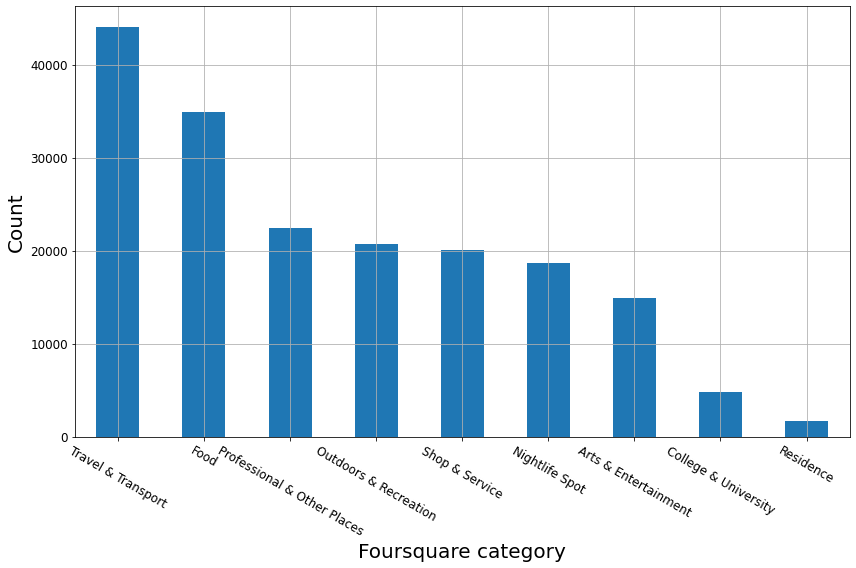

In [18]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True

ax = gdf_london_cleaned['category'].value_counts().plot.bar()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title("Anomalies of each Device", fontsize=30)
plt.xlabel("Foursquare category", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(rotation = -30)
# plt.legend(fontsize=12)
plt.grid()

## Locals

In [9]:
# get the locals
df_locals = gdf_london_cleaned[gdf_london_cleaned['tourist']=='n']
df_locals

,Unnamed: 0,User ID,Venue ID,Venue category name,time,date,id,sub_id,category,sub_category,tourist,lon,lat
2,2,163591,4ae0acf4f964a5208c8121e3,Pub,2012-04-03 18:38:58+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,n,-0.020657,51.587781
15,15,56338,4bb2438a35f0c9b6070abb83,Pub,2012-04-04 12:00:46+00:00,2012-04-04,14000,14001,Nightlife Spot,Bar,n,-0.084695,51.512665
16,16,83315,4c6e9c0e6af58cfa97b88c17,Pub,2012-04-04 12:21:21+00:00,2012-04-04,14000,14001,Nightlife Spot,Bar,n,-0.216744,51.493114
18,18,56338,4ad364e6f964a5201fe420e3,Pub,2012-04-04 14:55:06+00:00,2012-04-04,14000,14001,Nightlife Spot,Bar,n,-0.082840,51.506276
22,22,150594,4ac518c3f964a5203aa420e3,Pub,2012-04-04 17:01:24+00:00,2012-04-04,14000,14001,Nightlife Spot,Bar,n,-0.135107,51.513807
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182097,182097,72218,513b5626e4b0ab90b73d65b1,Real Estate Office,2013-05-28 17:14:22+00:00,2013-05-28,18000,18114,Shop & Service,Real Estate Office,n,-0.070254,51.592789
182102,182102,216862,4c57308112f0d13abf9006ad,Mongolian Restaurant,2012-12-22 20:51:10+00:00,2012-12-22,13000,13005,Food,Asian Restaurant,n,-0.142248,51.466164
182113,182113,6759,4c508d37250dd13a45c8c67b,Apres Ski Bar,2013-03-15 22:36:51+00:00,2013-03-15,15000,15053,Outdoors & Recreation,Ski Area,n,-0.138557,51.444806
182119,182119,58154,4bf533da706e20a14924aa98,College Rec Center,2013-09-16 10:13:26+00:00,2013-09-16,11000,11011,College & University,College Rec Center,n,-0.134711,51.494423


In [29]:
len(list(df_locals['User ID'].unique()))

608

In [21]:
# get the top 20 popular venues
top_venues_locals = df_locals['Venue ID'].value_counts()[0:20]


Foursquare API 1: fsq3SA2r/INEiszcpAcb94IvEE0c2czJftnxoYPSkHBx+x8=   
Foursquare API 2: fsq3C2PSDwUlQNwuiOq0z5ZMci/cq004Vvv9uOVvs77cvQ4=

In [20]:
# collect venue names via Foursquare API
# https://location.foursquare.com/developer/reference/place-details
headers = {
    "accept": "application/json",
    "Authorization": "fsq3SA2r/INEiszcpAcb94IvEE0c2czJftnxoYPSkHBx+x8="
}

count = 0
for venue_id in top_venues_locals.keys():
  venue_count = top_venues_locals[venue_id]
  venue_category = df_locals[df_locals['Venue ID']==venue_id]['category'].values[0]
  url = "https://api.foursquare.com/v3/places/{}".format(venue_id)
  response = requests.get(url, headers=headers)
  if 'invalid venue specified' not in response.text:
    # print(venue_id)
    # print(response.text)
    response_json = json.loads(response.text)
    venueName = response_json['name']
    print(str(count)+':'+venue_id)
    print(venueName+' & '+str(venue_count)+' & '+venue_category)
    count += 1


0:4acd8e7df964a52044cc20e3
London Waterloo Railway Station (WAT) & 158 & Travel & Transport
1:4acbc300f964a52058c520e3
London Euston Railway Station & 149 & Travel & Transport
2:4af33684f964a520c7eb21e3
London King's Cross Railway Station (KGX) & 111 & Travel & Transport
3:4ae83e74f964a5204bae21e3
London Paddington Railway Station (PAD) & 111 & Travel & Transport
4:4af47862f964a520d6f221e3
London Liverpool Street Railway Station (LST) & 108 & Travel & Transport
5:4d48ffc34509721eeb9b1fb0
Grove Park Traincrew Depot & 98 & Professional & Other Places
6:4c1f76d6e923ef3bbfbe4e54
West Ham DLR Station & 92 & Travel & Transport
7:4c4d624bdb2c20a12730b972
Westfield Stratford City & 92 & Shop & Service
8:4b76d450f964a5205e622ee3
Virgin Active & 92 & Outdoors & Recreation
9:4ac518f7f964a520c6af20e3
London St Pancras International Railway Station (STP) & 89 & Travel & Transport
10:5045b9b7e4b000beffba95f9
Valideus & 89 & Professional & Other Places
11:4aef4cd0f964a52060d721e3
Twickenham Green & 8

## Tourists

In [10]:
# get the tourists
df_tourists = gdf_london_cleaned[gdf_london_cleaned['tourist']=='y']
df_tourists

,Unnamed: 0,User ID,Venue ID,Venue category name,time,date,id,sub_id,category,sub_category,tourist,lon,lat
0,0,262915,4aec9f4bf964a52091c921e3,Pub,2012-04-03 18:00:39+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.090546,51.498044
1,1,176394,4ad9f6ddf964a520751c21e3,Pub,2012-04-03 18:15:19+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.104010,51.520118
3,3,206428,4adb1972f964a5205f2421e3,Pub,2012-04-03 18:41:27+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.143561,51.558523
4,4,18883,4ac518baf964a520dea120e3,Pub,2012-04-03 18:47:29+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.177416,51.556636
5,5,70148,4ac53702f964a52007b120e3,Pub,2012-04-03 19:02:34+00:00,2012-04-03,14000,14001,Nightlife Spot,Bar,y,-0.305714,51.505048
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182122,182122,218592,51633602e4b02cfd1f77c01e,Well,2013-04-11 08:16:21+00:00,2013-04-11,15000,15065,Outdoors & Recreation,Well,y,-0.191445,51.536016
182123,182123,544,51692f22e4b04a6f7dca039d,Middle School,2013-04-19 06:38:30+00:00,2013-04-19,16000,16036,Professional & Other Places,School,y,-0.240222,51.487264
182124,182124,544,51692f22e4b04a6f7dca039d,Middle School,2013-04-21 11:18:59+00:00,2013-04-21,16000,16036,Professional & Other Places,School,y,-0.240222,51.487264
182126,182126,158095,5196543b498ea8ef66acbc69,Research Laboratory,2013-07-04 15:38:07+00:00,2013-07-04,16000,16034,Professional & Other Places,Research Laboratory,y,-0.148466,51.522290


In [30]:
len(list(df_tourists['User ID'].unique()))

9097

In [23]:
# get the top 20 popular venues
top_venues_tourists = df_tourists['Venue ID'].value_counts()[0:20]


Foursquare API 1: fsq3SA2r/INEiszcpAcb94IvEE0c2czJftnxoYPSkHBx+x8=   
Foursquare API 2: fsq3C2PSDwUlQNwuiOq0z5ZMci/cq004Vvv9uOVvs77cvQ4=

In [24]:
# collect venue names via Foursquare API
# https://location.foursquare.com/developer/reference/place-details
headers = {
    "accept": "application/json",
    "Authorization": "fsq3SA2r/INEiszcpAcb94IvEE0c2czJftnxoYPSkHBx+x8="
}

count = 0
for venue_id in top_venues_tourists.keys():
  venue_count = top_venues_tourists[venue_id]
  venue_category = df_tourists[df_tourists['Venue ID']==venue_id]['category'].values[0]
  url = "https://api.foursquare.com/v3/places/{}".format(venue_id)
  response = requests.get(url, headers=headers)
  if 'invalid venue specified' not in response.text:
    # print(venue_id)
    # print(response.text)
    response_json = json.loads(response.text)
    venueName = response_json['name']
    print(str(count)+':'+venue_id)
    print(venueName+' & '+str(venue_count)+' & '+venue_category)
    count += 1


0:4acd8e7df964a52044cc20e3
London Waterloo Railway Station (WAT) & 1311 & Travel & Transport
1:4acbc300f964a52058c520e3
London Euston Railway Station & 1288 & Travel & Transport
2:4af33684f964a520c7eb21e3
London King's Cross Railway Station (KGX) & 1115 & Travel & Transport
3:4ae83e74f964a5204bae21e3
London Paddington Railway Station (PAD) & 1043 & Travel & Transport
4:4ac518f6f964a52052af20e3
London Victoria Railway Station (VIC) & 905 & Travel & Transport
5:4ac518f7f964a520c6af20e3
London St Pancras International Railway Station (STP) & 728 & Travel & Transport
6:4abf8c03f964a520079120e3
Harrods & 717 & Shop & Service
7:4af47862f964a520d6f221e3
London Liverpool Street Railway Station (LST) & 687 & Travel & Transport
8:4ad08b28f964a52064d820e3
Westfield London & 622 & Shop & Service
9:4c9c6a059c48236a1cb14dee
Piccadilly Circus & 605 & Outdoors & Recreation
10:4c4d624bdb2c20a12730b972
Westfield Stratford City & 555 & Shop & Service
11:4bcc08273740b7139c756365
London St Pancras Internat